In [3]:
# Librerias
import pandas as pd
import yaml
import numpy as np

# Cargando Yaml
with open("../config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

# Importando modulos
import sys
from pathlib import Path

from sklearn.metrics import mean_squared_error, r2_score

parent_folder = str(Path.cwd().parent)
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from src import filtering_vars as fv
from src import RFECV as fs
from src import regressions as r

In [4]:
import os
print(os.getcwd())

c:\Users\Lenovo User\Documents\GitHub\Proyecto-Polifenoles\Notebooks


In [5]:
import os
print(os.getcwd())

c:\Users\Lenovo User\Documents\GitHub\Proyecto-Polifenoles\Notebooks


In [6]:
# Cargando Base de Datos
df = pd.read_csv(r"../Data/DF_Final_No_Filtered.csv")

# Filtrado De Variables

Dada nuestra previa entrega, se ha discutido con los expertos la viabilidad de eliminación de las variables propuestas.

A continuación se aplicará la eliminación correspondiente a su retroalimentación.

In [7]:
# Creando PAD_media a partir de PAD_izq y PAD_der
df['PAD_media'] = df[['PAD_izq', 'PAD_der']].mean(axis=1)

In [8]:
# Eliminando variables correlacionadas y con un varianza casi nula.

vars_delete = config['Filtrado_Variables']['Umbral_Varianza'] + config['Filtrado_Variables']['Correlacionadas']

vars_delete = list(set(vars_delete))

df = df.drop(vars_delete, axis='columns')
print(f"Dada nuestra conversación con nuestros compañeros de Barcelona, se eliminarán {len(vars_delete)} variables.")

Dada nuestra conversación con nuestros compañeros de Barcelona, se eliminarán 86 variables.


# Reestructura De Datos

Los datos se encuentran repitiendo a cada sujeto 4 veces. Pues cada registro se divide en `Treatment` (Intervención y Control) y `Time` (Pre y Post).

Nos interesa conocer los efectos del experimento en el periodo Post de la Intervención con tomate.

Por lo que se estructurará la base de datos, de manera que nos funcione así.

En este modelo, predeciremos el efecto en el tratamiento (delta bdnf), así mismo aprovecharemos la manipulación de los datos para generar otra variable objetivo, que sería el
efecto neto (delta BDNF Intervención - delta BDNF Control).

In [9]:
# Generando deltas.

# Pivoteando para tener pre y post como columnas.
df_deltas = df.pivot(index=['id','Treatment'], columns='Time', values='bdnf').reset_index()
# Calculando delta por tratamiento
df_deltas['delta_bdnf'] = df_deltas['Post'] - df_deltas['Pre']

In [10]:
# Primer variable: Delta en Periodo de Tratamiento.
df_delta_I = df_deltas[df_deltas['Treatment'] == 'Intervencion']
df_delta_I = df_delta_I[['id','delta_bdnf']].rename(columns={'delta_bdnf':'delta_bdnf_Int'})

In [11]:
# Generando efecto neto.
df_delta_N = df_deltas.pivot(index=['id'], columns='Treatment', values='delta_bdnf').reset_index()
# Calculando delta por tratamiento
df_delta_N['delta_bdnf_Neto'] = df_delta_N['Intervencion'] - df_delta_N['Control']

df_delta_N = df_delta_N[['id','delta_bdnf_Neto']]

deltas = df_delta_N.merge(df_delta_I)

del df_delta_N,df_delta_I,df_deltas

Generando Dataset para predecir con el estado basal del periodo intervención.

Se agregarán variables objetivos: 

    - delta bdnf en periodo de intervención
    - delta bdnf neto : delta intervención - delta control

In [12]:
# Generando Dataset.
df_pred = df[(df['Treatment'] == 'Intervencion') & (df['Time'] == 'Pre')].reset_index(drop=True)

# Agregando Variables Objetivo
df_pred = df_pred.merge(deltas)
# Eliminando columnas no deseadas en entrenamiento
df_pred = df_pred.drop(columns= config['Tratamiento_Variables']['Objetivos'] + ['id', 'grupo', 'Treatment', 'Time'])

# Para este modelo, eliminaremos la del efecto neto, únicamente modelaremos el efecto en intervención
del df_pred['delta_bdnf_Neto']

# Modelado

## Entrenamiento del Modelo Predictivo Final (Baseline)

Tras el proceso de selección de características mediante **RFECV**, hemos reducido el espacio dimensional de **444 a 101 variables**. Este subconjunto representa el "núcleo informativo" que maximiza el coeficiente de determinación ($R^2$) minimizando el ruido estructural.

### 📋 Configuración del Experimento
En esta etapa, procederemos a entrenar un modelo **XGBoost Regressor** bajo las siguientes premisas:

1.  **Modelo Base (Baseline):** Se utilizan hiperparámetros genéricos y balanceados. El objetivo es establecer un punto de referencia (benchmarking) antes de realizar una optimización fina (*Hyperparameter Tuning*).
2.  **Variables Seleccionadas:** El entrenamiento se restringe exclusivamente a las **101 variables** que obtuvieron un `Ranking == 1`, asegurando que el modelo sea más parsimonioso y eficiente.
3.  **Evaluación Robusta:** Se implementa una división de datos **80/20** para entrenamiento y prueba, permitiendo medir la capacidad de generalización del modelo en datos no observados.

### 📈 Métricas de Control
Para evaluar la calidad de la respuesta clínica predicha, analizaremos:
* **$R^2$ (R-Squared):** Varianza explicada por el modelo.
* **MAE & RMSE:** Magnitud del error en las unidades originales de la variable clínica.
* **MAPE:** Error porcentual para validar la precisión relativa del modelo.

> **Nota:** Este modelo servirá como base para futuras interpretaciones de impacto individual mediante valores SHAP.

---
# A Continuación, se propone un segundo modelo base.

Estimamos el bdnf utilizando las dos mediciones basales (periodo control e intervención).
Este enfoque, predice el valor tal cual y no el efecto del tratamiento, resultará interesante optimizar y robustecer ambos.

In [13]:
# Filtrar datos solo con periodo Pre

df_pre = df[df["Time"] == "Pre"].copy()

print("Dataset Periodo Pre:", df_pre.shape)
df_pre.head()

Dataset Periodo Pre: (84, 455)


,id,grupo,frec_alcohol_audit,puntaje_audit,Palabras_moca,memoria_moca,puntaje_moca,edad,edo_civil,personas_hogar,...,bacterias_sed_Negativo,celulas_epiteliales_sed_Negativo,hematies_sed_(10-20),hematies_sed_Negativo,fibra_mucoide_sed_Negativo,num_depo_Dos + Por Día,num_depo_Una Por Día,leucocitos_sed_Moderado,leucocitos_sed_Negativo,PAD_media
0,1,1,2,5,29,4,29,48.71,1,4,...,1,1,0,1,1,0,1,0,1,64.5
2,1,1,2,5,29,4,29,49.05,1,4,...,1,1,0,1,1,1,0,0,0,65.0
4,2,2,2,2,21,4,28,54.48,2,3,...,1,1,0,1,1,0,0,0,1,77.5
6,2,2,2,2,21,4,28,54.82,2,3,...,1,1,0,1,1,0,0,0,1,75.0
8,3,1,2,2,18,3,28,41.72,2,3,...,1,1,0,1,1,0,0,0,1,95.0


In [14]:
# Confirmación de que ya no aparezca periodo Post

df_pre["Time"] if "periodo" in df_pre.columns else "Periodo eliminado correctamente", print("Filas Post restantes:", (df_pre == "Post").sum().sum())
df["Time"] = df["Time"].astype(str).str.strip().str.lower()

Filas Post restantes: 0


In [15]:
df_pre = df[df["Time"] == "pre"].copy()
print(df_pre.shape)

(84, 455)


# Random Forest - BDNF

In [16]:
# Definir objetivo - BDNF

target = "bdnf"

y = df_pre[target]

print("Objetivo:", target)
print("Tamaño de y:", y.shape)

Objetivo: bdnf
Tamaño de y: (84,)


In [18]:
# Definir predictores

X = df_pre.drop(columns=[target, "ID"], errors="ignore")

print("Tamaño de X:", X.shape)

Tamaño de X: (84, 454)


In [19]:
# Eliminar columnas no numéricas

X = X.select_dtypes(include=["int64", "float64"])

print("X solo numéricas:", X.shape)

X solo numéricas: (84, 452)


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Valores faltantes - no NaN

imputer = SimpleImputer(strategy="median")

X_imputed = imputer.fit_transform(X)

In [21]:
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

print("NaNs restantes:", X_imputed.isna().sum().sum())

NaNs restantes: 0


In [22]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.15,
    random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (71, 452)
Test: (13, 452)


Evaluar y comparar varios modelos a base de df.pre

In [24]:
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


# Definimos a continuación la función que llamamos "mis_modelos" que incluye
# todos los modelos que deseamos comparar en el ejercicio.


def mis_modelos():
  modelos, nombres = list(), list()


  # Regresión Lineal - Linear Regression-LR:
  modelos.append(LinearRegression())
  nombres.append('LR')

  # k-Vecinos más Cercanos Regressor - kNN:
  modelos.append(KNeighborsRegressor( n_neighbors=5))
  nombres.append('kNN')

  # Árbol de decisiones Regressor - DTree:
  modelos.append(DecisionTreeRegressor( random_state=7,
                                          max_depth = 3,
                                          min_samples_split=2,
                                         ))
  nombres.append('DTree')


  # Bosque Aleatorio Regressor - RandomForest-RF:
  modelos.append(RandomForestRegressor( max_depth=3,
                                         min_samples_split=2,
                                         random_state=0, ))
  nombres.append('RF')


  # XGBoosting Regressor:
  modelos.append(XGBRegressor( booster= 'gbtree',
                               n_estimators=100,
                               max_depth= 1,
                               learning_rate=0.2,
                               objective='reg:squarederror', 
                               subsample=0.9,
                               random_state=5,
                               n_jobs=-1
                                ))
  nombres.append('XGBoost')


  # Red neuronal de Perceptrón Multicapa Regressor - MLP:
  modelos.append(MLPRegressor( random_state=1,
                               max_iter=300,
                               activation='relu', 
                               learning_rate='constant',
                               learning_rate_init=0.001,
                                ))
  nombres.append('MLP')




  # Máquina de Vectores de Soporte Regressor - SVM:
  modelos.append(SVR( gamma='auto') )
  nombres.append('SVM')

  return modelos, nombres

Aplicamos GroupKFold para tener un solo dato por cada uno de los 42 pacientes y no sacar conclusiones no válidas. 

GitHub Copilot

Aquí está el código ajustado para usar **GroupKFold** con el ID en lugar de RepeatedKFold:



In [25]:
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
from sklearn.impute import SimpleImputer

# Preparar datos para predicción de BDNF
target = "bdnf"
y = df_pre[target]
X = df_pre.drop(columns=[target, "id"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])

# Reemplazar NaN con la mediana
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Obtener IDs para GroupKFold
groups = df_pre["id"].values

# Definir scorer para MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Scoring como diccionario
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'mape': mape_scorer
}

# Validación por grupos
micv = GroupKFold(n_splits=5)

# Reutilizar función de modelos
modelos, nombres = mis_modelos()
resultados = []

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])
    scores = cross_validate(
        pipeline,
        X,
        y,
        scoring=scoring,
        cv=micv,
        groups=groups,
        return_train_score=True
    )
    resultados.append(scores)
    
    test_r2 = np.mean(scores['test_r2'])
    test_mse = -np.mean(scores['test_neg_mean_squared_error'])
    test_rmse = np.sqrt(test_mse)
    test_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    test_mape = -np.mean(scores['test_mape'])
    
    print(f">> {nombres[i]:<15} | R²: {test_r2:.4f} | RMSE: {test_rmse:.2f} | MAE: {test_mae:.2f} | MAPE: {test_mape:.4f}")

print("\n✓ Cross-validation completada exitosamente")

>> LR              | R²: -4.4993 | RMSE: 43.75 | MAE: 33.06 | MAPE: 2.1265
>> kNN             | R²: -0.0980 | RMSE: 20.55 | MAE: 15.60 | MAPE: 0.9531
>> DTree           | R²: -0.9981 | RMSE: 26.96 | MAE: 20.33 | MAPE: 1.0857
>> RF              | R²: 0.0373 | RMSE: 19.20 | MAE: 14.73 | MAPE: 0.9173
>> XGBoost         | R²: -0.0629 | RMSE: 19.45 | MAE: 13.98 | MAPE: 0.8159
>> MLP             | R²: -619.3623 | RMSE: 481.12 | MAE: 460.70 | MAPE: 28.1454
>> SVM             | R²: -0.0846 | RMSE: 20.42 | MAE: 15.13 | MAPE: 0.8347

✓ Cross-validation completada exitosamente


RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits)
 Modelo     Test_R2  Test_R2_std  Test_RMSE   Test_MAE    Train_R2  Overfitting
     LR   -4.499306     2.099733  43.750987  33.063020    1.000000     5.499306
    kNN   -0.097999     0.132446  20.548787  15.603719    0.225373     0.323372
  DTree   -0.998115     0.719163  26.957148  20.325135    0.767310     1.765426
     RF    0.037269     0.104445  19.200997  14.728699    0.773744     0.736474
XGBoost   -0.062893     0.404428  19.450725  13.978295    0.978308     1.041200
    MLP -619.362266   126.165658 481.119454 460.704806 -588.547740    30.814526
    SVM   -0.084556     0.090473  20.418128  15.133783    0.025007     0.109563


INTERPRETACIÓN DETALLADA

📊 LR
------------------------------------------------------------
  R² Test: -4.4993 - ✗ POBRE - R² negativo (peor que predecir la media)
  RMSE: 43.75 (Error cuadrático medio)
  MAE: 33.06 (Error absoluto medio)
  Overfitting (Train R² - Test R²): 5.4993 - ✗ OVE

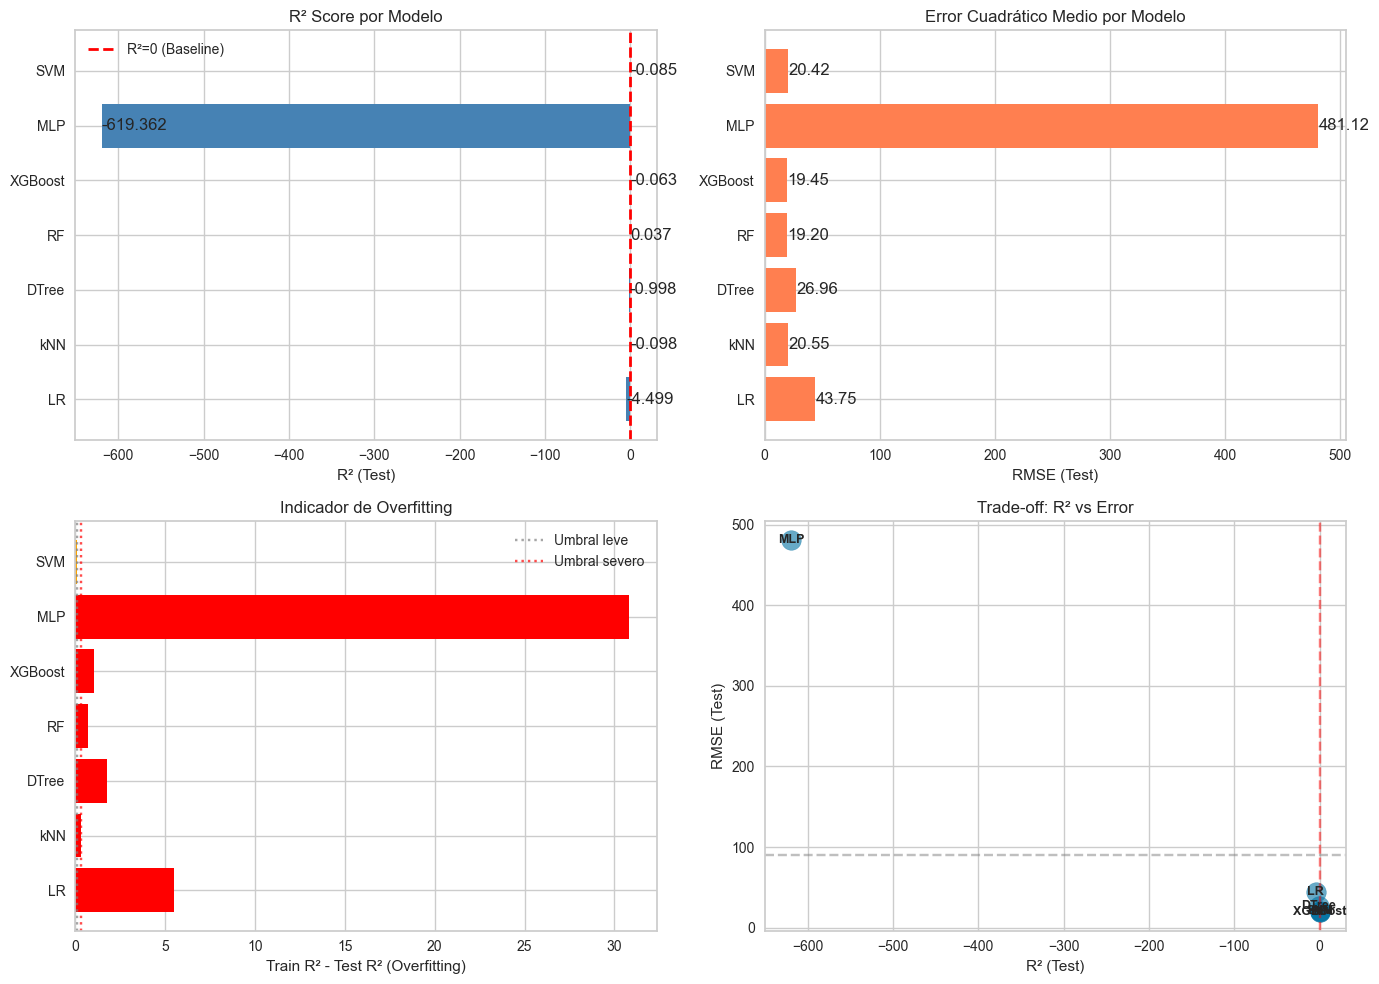


✓ Gráfico guardado: Comparativa_Modelos_Baseline.png


In [26]:
# Interpretación de Resultados - Comparativa de Modelos

import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame con resumen de resultados
resultados_resumen = []

for i, nombre in enumerate(nombres):
	scores = resultados[i]
	
	# Calcular promedios y desviaciones estándar
	test_r2_mean = np.mean(scores['test_r2'])
	test_r2_std = np.std(scores['test_r2'])
	test_mse_mean = -np.mean(scores['test_neg_mean_squared_error'])  # Convertir de negativo a positivo
	test_rmse_mean = np.sqrt(test_mse_mean)
	test_mae_mean = -np.mean(scores['test_neg_mean_absolute_error'])
	
	train_r2_mean = np.mean(scores['train_r2'])
	train_rmse_mean = np.sqrt(-np.mean(scores['train_neg_mean_squared_error']))
	
	# Calcular overfitting
	overfitting = train_r2_mean - test_r2_mean
	
	resultados_resumen.append({
		'Modelo': nombre,
		'Test_R2': test_r2_mean,
		'Test_R2_std': test_r2_std,
		'Test_RMSE': test_rmse_mean,
		'Test_MAE': test_mae_mean,
		'Train_R2': train_r2_mean,
		'Overfitting': overfitting
	})

df_resumen = pd.DataFrame(resultados_resumen)

print("="*80)
print("RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits)")
print("="*80)
print(df_resumen.to_string(index=False))
print("\n")

# Interpretación detallada
print("="*80)
print("INTERPRETACIÓN DETALLADA")
print("="*80)

for idx, row in df_resumen.iterrows():
	print(f"\n📊 {row['Modelo'].upper()}")
	print("-" * 60)
	
	r2 = row['Test_R2']
	rmse = row['Test_RMSE']
	mae = row['Test_MAE']
	overfit = row['Overfitting']
	
	# R² interpretation
	if r2 > 0.7:
		r2_status = "✓ EXCELENTE - Modelo explica >70% de la varianza"
	elif r2 > 0.5:
		r2_status = "✓ BUENO - Modelo explica 50-70% de la varianza"
	elif r2 > 0.3:
		r2_status = "⚠ ACEPTABLE - Modelo explica 30-50% de la varianza"
	elif r2 > 0:
		r2_status = "⚠ DÉBIL - Modelo explica <30% de la varianza"
	else:
		r2_status = "✗ POBRE - R² negativo (peor que predecir la media)"
	
	print(f"  R² Test: {r2:.4f} - {r2_status}")
	print(f"  RMSE: {rmse:.2f} (Error cuadrático medio)")
	print(f"  MAE: {mae:.2f} (Error absoluto medio)")
	
	# Overfitting check
	if overfit < 0.1:
		overfit_status = "✓ SIN OVERFITTING SIGNIFICATIVO"
	elif overfit < 0.3:
		overfit_status = "⚠ OVERFITTING LEVE"
	else:
		overfit_status = "✗ OVERFITTING SEVERO"
	
	print(f"  Overfitting (Train R² - Test R²): {overfit:.4f} - {overfit_status}")

# Ranking de modelos
print("\n" + "="*80)
print("RANKING POR DESEMPEÑO (Test R²)")
print("="*80)
df_ranking = df_resumen.sort_values('Test_R2', ascending=False).reset_index(drop=True)
for idx, row in df_ranking.iterrows():
	print(f"{idx+1}. {row['Modelo']:<12} - R²: {row['Test_R2']:>7.4f} | RMSE: {row['Test_RMSE']:>7.2f} | MAE: {row['Test_MAE']:>7.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R² comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(df_resumen['Modelo'], df_resumen['Test_R2'], color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='R²=0 (Baseline)')
ax1.set_xlabel('R² (Test)')
ax1.set_title('R² Score por Modelo')
ax1.legend()
for i, v in enumerate(df_resumen['Test_R2']):
	ax1.text(v + 0.02, i, f'{v:.3f}', va='center')

# Plot 2: RMSE comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(df_resumen['Modelo'], df_resumen['Test_RMSE'], color='coral')
ax2.set_xlabel('RMSE (Test)')
ax2.set_title('Error Cuadrático Medio por Modelo')
for i, v in enumerate(df_resumen['Test_RMSE']):
	ax2.text(v + 0.5, i, f'{v:.2f}', va='center')

# Plot 3: Overfitting
ax3 = axes[1, 0]
colors = ['green' if x < 0.1 else 'orange' if x < 0.3 else 'red' for x in df_resumen['Overfitting']]
bars3 = ax3.barh(df_resumen['Modelo'], df_resumen['Overfitting'], color=colors)
ax3.set_xlabel('Train R² - Test R² (Overfitting)')
ax3.set_title('Indicador de Overfitting')
ax3.axvline(x=0.1, color='gray', linestyle=':', alpha=0.7, label='Umbral leve')
ax3.axvline(x=0.3, color='red', linestyle=':', alpha=0.7, label='Umbral severo')
ax3.legend()

# Plot 4: R² vs RMSE scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(df_resumen['Test_R2'], df_resumen['Test_RMSE'], s=200, alpha=0.6)
for idx, row in df_resumen.iterrows():
	ax4.annotate(row['Modelo'], (row['Test_R2'], row['Test_RMSE']), 
				ha='center', va='center', fontsize=9, fontweight='bold')
ax4.set_xlabel('R² (Test)')
ax4.set_ylabel('RMSE (Test)')
ax4.set_title('Trade-off: R² vs Error')
ax4.axhline(y=df_resumen['Test_RMSE'].mean(), color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../Entregables/UdeBarcelona/Comparativa_Modelos_Baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: Comparativa_Modelos_Baseline.png")


RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits) + MAPE
 Modelo     Test_R2  Test_RMSE   Test_MAE  Test_MAPE  Overfitting
     LR   -4.499306  43.750987  33.063020   2.126539     5.499306
    kNN   -0.097999  20.548787  15.603719   0.953150     0.323372
  DTree   -0.998115  26.957148  20.325135   1.085660     1.765426
     RF    0.037269  19.200997  14.728699   0.917295     0.736474
XGBoost   -0.062893  19.450725  13.978295   0.815930     1.041200
    MLP -619.362266 481.119454 460.704806  28.145351    30.814526
    SVM   -0.084556  20.418128  15.133783   0.834708     0.109563


INTERPRETACIÓN DETALLADA

📊 LR
--------------------------------------------------------------------------------
  R² Test: -4.4993 - ✗ POBRE - R² negativo (peor que predecir la media)
  RMSE: 43.7510 (Error cuadrático medio)
  MAE: 33.0630 (Error absoluto medio)
  MAPE: 2.1265 (212.65%) - ✗ POBRE (>50%)
  Overfitting (Train R² - Test R²): 5.4993 - ✗ OVERFITTING SEVERO

📊 KNN
----------------

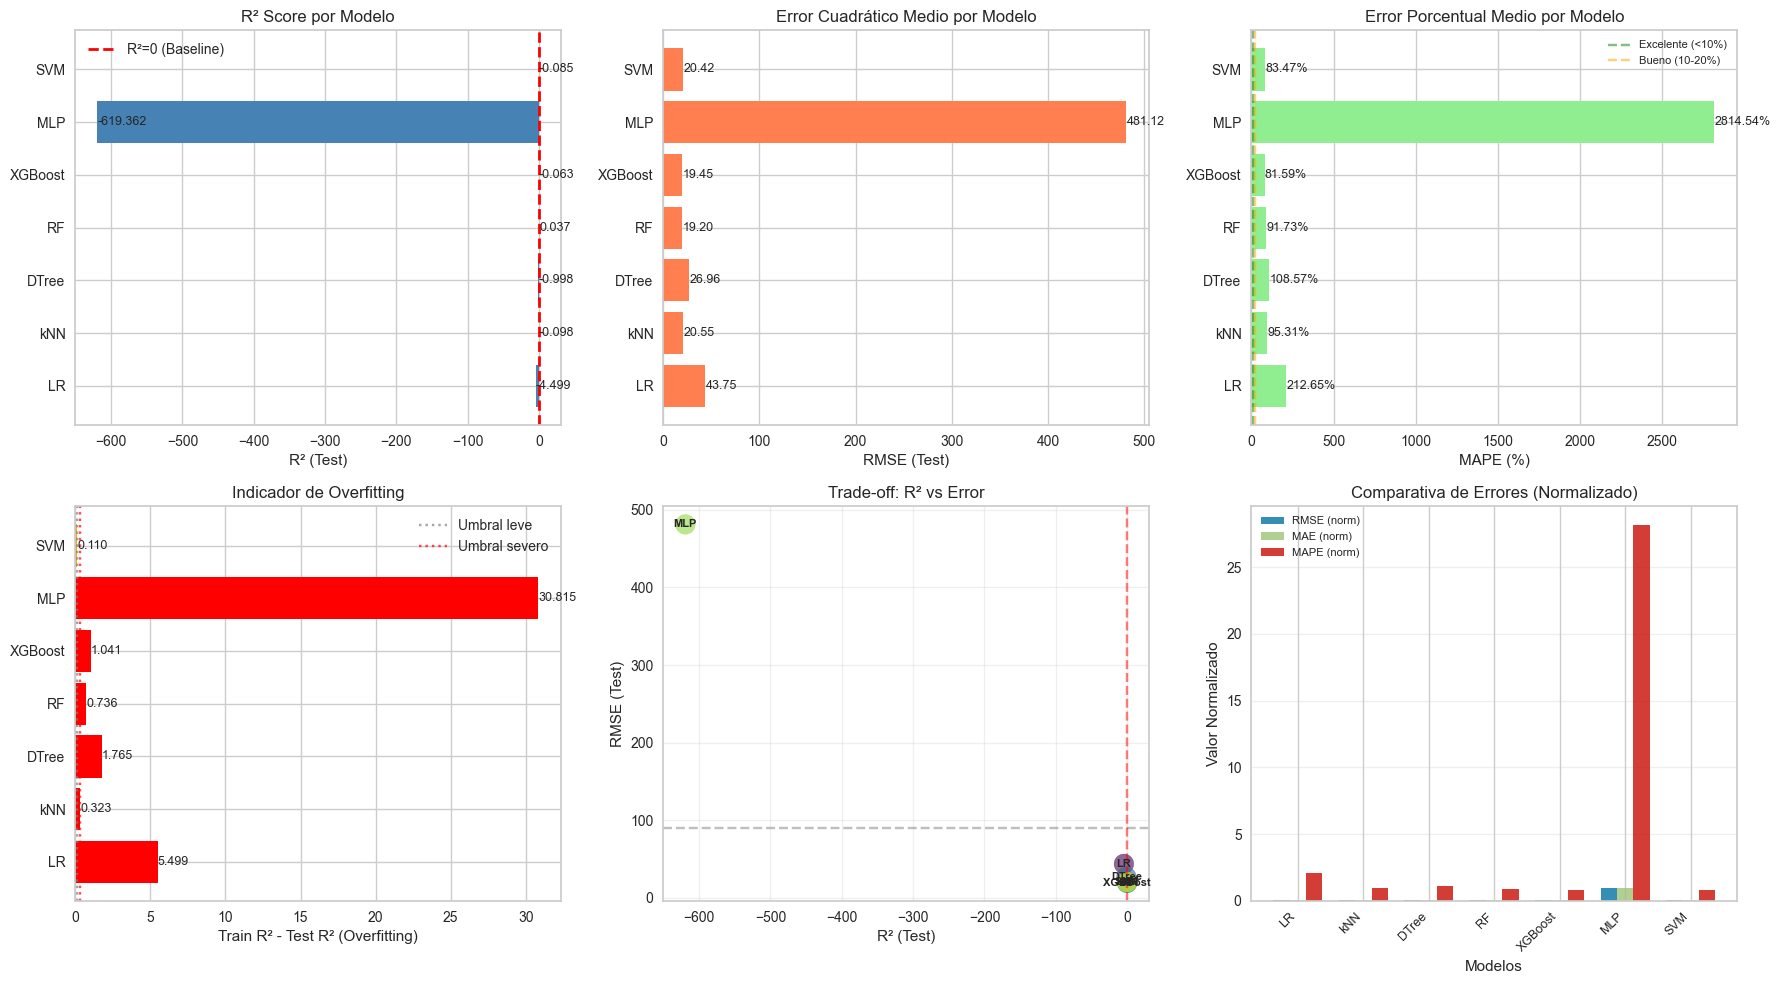


✓ Gráfico guardado: Comparativa_Modelos_Baseline_con_MAPE.png
✓ Resultados guardados en: Resultados_Baseline_con_MAPE.xlsx


In [28]:
import seaborn as sns

# Interpretación de Resultados - Comparativa de Modelos CON MAPE

import matplotlib.pyplot as plt

# Crear DataFrame con resumen de resultados
resultados_resumen = []

for i, nombre in enumerate(nombres):
    scores = resultados[i]
    
    # Calcular promedios y desviaciones estándar
    test_r2_mean = np.mean(scores['test_r2'])
    test_r2_std = np.std(scores['test_r2'])
    test_mse_mean = -np.mean(scores['test_neg_mean_squared_error'])
    test_rmse_mean = np.sqrt(test_mse_mean)
    test_mae_mean = -np.mean(scores['test_neg_mean_absolute_error'])
    test_mape_mean = -np.mean(scores['test_mape']) if 'test_mape' in scores else np.nan
    
    train_r2_mean = np.mean(scores['train_r2'])
    train_rmse_mean = np.sqrt(-np.mean(scores['train_neg_mean_squared_error']))
    
    # Calcular overfitting
    overfitting = train_r2_mean - test_r2_mean
    
    resultados_resumen.append({
        'Modelo': nombre,
        'Test_R2': test_r2_mean,
        'Test_R2_std': test_r2_std,
        'Test_RMSE': test_rmse_mean,
        'Test_MAE': test_mae_mean,
        'Test_MAPE': test_mape_mean,
        'Train_R2': train_r2_mean,
        'Overfitting': overfitting
    })

df_resumen = pd.DataFrame(resultados_resumen)

print("="*110)
print("RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits) + MAPE")
print("="*110)
print(df_resumen[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Overfitting']].to_string(index=False))
print("\n")

# Interpretación detallada
print("="*110)
print("INTERPRETACIÓN DETALLADA")
print("="*110)

for idx, row in df_resumen.iterrows():
    print(f"\n📊 {row['Modelo'].upper()}")
    print("-" * 80)
    
    r2 = row['Test_R2']
    rmse = row['Test_RMSE']
    mae = row['Test_MAE']
    mape = row['Test_MAPE']
    overfit = row['Overfitting']
    
    # R² interpretation
    if r2 > 0.7:
        r2_status = "✓ EXCELENTE - Modelo explica >70% de la varianza"
    elif r2 > 0.5:
        r2_status = "✓ BUENO - Modelo explica 50-70% de la varianza"
    elif r2 > 0.3:
        r2_status = "⚠ ACEPTABLE - Modelo explica 30-50% de la varianza"
    elif r2 > 0:
        r2_status = "⚠ DÉBIL - Modelo explica <30% de la varianza"
    else:
        r2_status = "✗ POBRE - R² negativo (peor que predecir la media)"
    
    print(f"  R² Test: {r2:.4f} - {r2_status}")
    print(f"  RMSE: {rmse:.4f} (Error cuadrático medio)")
    print(f"  MAE: {mae:.4f} (Error absoluto medio)")
    
    # MAPE interpretation
    if not np.isnan(mape):
        if mape < 0.1:
            mape_status = "✓ EXCELENTE (<10%)"
        elif mape < 0.2:
            mape_status = "✓ MUY BUENO (10-20%)"
        elif mape < 0.5:
            mape_status = "⚠ ACEPTABLE (20-50%)"
        else:
            mape_status = "✗ POBRE (>50%)"
        print(f"  MAPE: {mape:.4f} ({mape*100:.2f}%) - {mape_status}")
    
    # Overfitting check
    if overfit < 0.1:
        overfit_status = "✓ SIN OVERFITTING SIGNIFICATIVO"
    elif overfit < 0.3:
        overfit_status = "⚠ OVERFITTING LEVE"
    else:
        overfit_status = "✗ OVERFITTING SEVERO"
    
    print(f"  Overfitting (Train R² - Test R²): {overfit:.4f} - {overfit_status}")

# Ranking de modelos
print("\n" + "="*110)
print("RANKING POR DESEMPEÑO (Test R²)")
print("="*110)
df_ranking = df_resumen.sort_values('Test_R2', ascending=False).reset_index(drop=True)
for idx, row in df_ranking.iterrows():
    print(f"{idx+1}. {row['Modelo']:<15} | R²: {row['Test_R2']:>7.4f} | RMSE: {row['Test_RMSE']:>7.4f} | MAE: {row['Test_MAE']:>7.4f} | MAPE: {row['Test_MAPE']:>7.4f} | Overfit: {row['Overfitting']:>7.4f}")

# Visualización mejorada con MAPE
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: R² comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(df_resumen['Modelo'], df_resumen['Test_R2'], color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='R²=0 (Baseline)')
ax1.set_xlabel('R² (Test)')
ax1.set_title('R² Score por Modelo')
ax1.legend()
for i, v in enumerate(df_resumen['Test_R2']):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 2: RMSE comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(df_resumen['Modelo'], df_resumen['Test_RMSE'], color='coral')
ax2.set_xlabel('RMSE (Test)')
ax2.set_title('Error Cuadrático Medio por Modelo')
for i, v in enumerate(df_resumen['Test_RMSE']):
    ax2.text(v + 0.5, i, f'{v:.2f}', va='center', fontsize=9)

# Plot 3: MAPE comparison (NUEVO)
ax3 = axes[0, 2]
valid_mape = df_resumen[~df_resumen['Test_MAPE'].isna()]
if len(valid_mape) > 0:
    bars3 = ax3.barh(valid_mape['Modelo'], valid_mape['Test_MAPE']*100, color='lightgreen')
    ax3.set_xlabel('MAPE (%)')
    ax3.set_title('Error Porcentual Medio por Modelo')
    ax3.axvline(x=10, color='green', linestyle='--', alpha=0.5, label='Excelente (<10%)')
    ax3.axvline(x=20, color='orange', linestyle='--', alpha=0.5, label='Bueno (10-20%)')
    ax3.legend(fontsize=8)
    for i, (idx, row) in enumerate(valid_mape.iterrows()):
        ax3.text(row['Test_MAPE']*100 + 1, i, f'{row["Test_MAPE"]*100:.2f}%', va='center', fontsize=9)

# Plot 4: Overfitting
ax4 = axes[1, 0]
colors = ['green' if x < 0.1 else 'orange' if x < 0.3 else 'red' for x in df_resumen['Overfitting']]
bars4 = ax4.barh(df_resumen['Modelo'], df_resumen['Overfitting'], color=colors)
ax4.set_xlabel('Train R² - Test R² (Overfitting)')
ax4.set_title('Indicador de Overfitting')
ax4.axvline(x=0.1, color='gray', linestyle=':', alpha=0.7, label='Umbral leve')
ax4.axvline(x=0.3, color='red', linestyle=':', alpha=0.7, label='Umbral severo')
ax4.legend()
for i, v in enumerate(df_resumen['Overfitting']):
    ax4.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 5: R² vs RMSE scatter
ax5 = axes[1, 1]
scatter = ax5.scatter(df_resumen['Test_R2'], df_resumen['Test_RMSE'], s=200, alpha=0.6, c=range(len(df_resumen)), cmap='viridis')
for idx, row in df_resumen.iterrows():
    ax5.annotate(row['Modelo'], (row['Test_R2'], row['Test_RMSE']), 
                ha='center', va='center', fontsize=8, fontweight='bold')
ax5.set_xlabel('R² (Test)')
ax5.set_ylabel('RMSE (Test)')
ax5.set_title('Trade-off: R² vs Error')
ax5.axhline(y=df_resumen['Test_RMSE'].mean(), color='gray', linestyle='--', alpha=0.5)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax5.grid(alpha=0.3)

# Plot 6: Radar/Comparación múltiple - RMSE vs MAE vs MAPE (normalizado)
ax6 = axes[1, 2]
valid_data = df_resumen[~df_resumen['Test_MAPE'].isna()].copy()
if len(valid_data) > 0:
    # Normalizar métricas para comparación
    valid_data['RMSE_norm'] = valid_data['Test_RMSE'] / valid_data['Test_RMSE'].max()
    valid_data['MAE_norm'] = valid_data['Test_MAE'] / valid_data['Test_MAE'].max()
    valid_data['MAPE_norm'] = valid_data['Test_MAPE']
    
    x = np.arange(len(valid_data))
    width = 0.25
    
    ax6.bar(x - width, valid_data['RMSE_norm'], width, label='RMSE (norm)', alpha=0.8)
    ax6.bar(x, valid_data['MAE_norm'], width, label='MAE (norm)', alpha=0.8)
    ax6.bar(x + width, valid_data['MAPE_norm'], width, label='MAPE (norm)', alpha=0.8)
    
    ax6.set_xlabel('Modelos')
    ax6.set_ylabel('Valor Normalizado')
    ax6.set_title('Comparativa de Errores (Normalizado)')
    ax6.set_xticks(x)
    ax6.set_xticklabels(valid_data['Modelo'], rotation=45, ha='right', fontsize=9)
    ax6.legend(fontsize=8)
    ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../Entregables/UdeBarcelona/Comparativa_Modelos_Baseline_con_MAPE.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: Comparativa_Modelos_Baseline_con_MAPE.png")

# Guardar tabla resumida en Excel
df_resumen[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Overfitting']].to_excel(
    "../Entregables/UdeBarcelona/Resultados_Baseline_con_MAPE.xlsx",
    index=False
)
print("✓ Resultados guardados en: Resultados_Baseline_con_MAPE.xlsx")

In [27]:
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

# Agregar MAPE al scoring
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

# Validación por grupos
micv = GroupKFold(n_splits=5)

# Reutilizar función de modelos
modelos, nombres = mis_modelos()
resultados = []

print("\n" + "="*100)
print("ENTRENAMIENTO DE MODELOS CON GroupKFold (INCLUYENDO MAPE)")
print("="*100 + "\n")

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])
    scores = cross_validate(
        pipeline,
        X,
        y,
        scoring=scoring,
        cv=micv,
        groups=groups,
        return_train_score=True
    )
    resultados.append(scores)
    
    test_r2 = np.mean(scores['test_r2'])
    test_mse = -np.mean(scores['test_neg_mean_squared_error'])
    test_rmse = np.sqrt(test_mse)
    test_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    test_mape = -np.mean(scores['test_mape'])
    
    print(f">> {nombres[i]:<15} | R²: {test_r2:7.4f} | RMSE: {test_rmse:7.2f} | MAE: {test_mae:7.2f} | MAPE: {test_mape:7.4f}")

print("\n✓ Cross-validation con MAPE completada exitosamente")


ENTRENAMIENTO DE MODELOS CON GroupKFold (INCLUYENDO MAPE)

>> LR              | R²: -4.4993 | RMSE:   43.75 | MAE:   33.06 | MAPE:  2.1265
>> kNN             | R²: -0.0980 | RMSE:   20.55 | MAE:   15.60 | MAPE:  0.9531
>> DTree           | R²: -0.9981 | RMSE:   26.96 | MAE:   20.33 | MAPE:  1.0857
>> RF              | R²:  0.0373 | RMSE:   19.20 | MAE:   14.73 | MAPE:  0.9173
>> XGBoost         | R²: -0.0629 | RMSE:   19.45 | MAE:   13.98 | MAPE:  0.8159
>> MLP             | R²: -619.3623 | RMSE:  481.12 | MAE:  460.70 | MAPE: 28.1454
>> SVM             | R²: -0.0846 | RMSE:   20.42 | MAE:   15.13 | MAPE:  0.8347

✓ Cross-validation con MAPE completada exitosamente


GitHub Copilot

Aquí está el código para visualizar cómo se agrupan los datos con **GroupKFold**:



In [29]:
# Visualizar cómo GroupKFold agrupa los datos por ID
from sklearn.model_selection import GroupKFold

# Preparar datos
target = "bdnf"
y = df_pre[target]
X = df_pre.drop(columns=[target, "id"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])
groups = df_pre["id"].values

# Crear splits con GroupKFold
micv = GroupKFold(n_splits=5)

# Visualizar cada fold
for fold, (train_idx, test_idx) in enumerate(micv.split(X, y, groups)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold + 1}')
    print(f'{"="*60}')
    
    # Obtener IDs en train y test
    train_ids = df_pre.iloc[train_idx]['id'].unique()
    test_ids = df_pre.iloc[test_idx]['id'].unique()
    
    print(f'Train - Número de muestras: {len(train_idx)}, Número de IDs únicos: {len(train_ids)}')
    print(f'Test  - Número de muestras: {len(test_idx)}, Número de IDs únicos: {len(test_ids)}')
    print(f'\nTrain IDs: {sorted(train_ids)}')
    print(f'Test IDs:  {sorted(test_ids)}')
    
    # Verificar que no hay solapamiento
    overlap = set(train_ids) & set(test_ids)
    if overlap:
        print(f'⚠️ ADVERTENCIA: IDs solapados: {overlap}')
    else:
        print(f'✓ Sin solapamiento - Validación correcta')

# Resumen final
print(f'\n{"="*60}')
print('RESUMEN FINAL')
print(f'{"="*60}')
print(f'Total de muestras: {len(df_pre)}')
print(f'Total de IDs únicos: {df_pre["id"].nunique()}')
print(f'Muestras por ID: {df_pre.groupby("id").size().describe()}')


FOLD 1
Train - Número de muestras: 66, Número de IDs únicos: 33
Test  - Número de muestras: 18, Número de IDs únicos: 9

Train IDs: [np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(27), np.int64(28), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(41), np.int64(43), np.int64(44), np.int64(45)]
Test IDs:  [np.int64(2), np.int64(7), np.int64(13), np.int64(18), np.int64(23), np.int64(29), np.int64(35), np.int64(40), np.int64(47)]
✓ Sin solapamiento - Validación correcta

FOLD 2
Train - Número de muestras: 66, Número de IDs únicos: 33
Test  - Número de muestras: 18, Número de IDs únicos: 9

Train IDs: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int6



**Lo que visualiza este código:**

1. **Número de muestras en train y test** para cada fold
2. **IDs únicos** en cada conjunto
3. **Validación de no solapamiento** - asegura que cada ID está solo en train o test
4. **Estadísticas finales** del dataset

Esto es importante para verificar que GroupKFold está funcionando correctamente y no está mezclando datos del mismo paciente entre train y test.



**Cambios principales:**

1. **GroupKFold**: Reemplaza `RepeatedKFold` con `GroupKFold(n_splits=5)`
2. **Parámetro `groups`**: Se añade `groups=groups` en `cross_validate()` para validar por ID
3. **Variables correctas**: Usa `X` e `y` del dataset `df_pre`
4. **Sin duplicados**: Elimina la lógica conflictiva anterior

Similar code found with 1 license type

In [30]:
y_pred = rf_bdnf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("Baseline Random Forest - BDNF (Pre)")
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

NameError: name 'rf_bdnf' is not defined

Aquí está el código para evaluar Ridge y ElasticNet con GroupKFold en el mismo dataframe:



In [31]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.preprocessing import StandardScaler

# Preparar datos para predicción de BDNF
target = "bdnf"
y = df_pre[target]
X = df_pre.drop(columns=[target, "id"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])

# Obtener IDs para GroupKFold
groups = df_pre["id"].values

# Definir modelos incluyendo Ridge y ElasticNet
def mis_modelos_extendidos():
  modelos, nombres = list(), list()
  
  modelos.append(LinearRegression())
  nombres.append('LR')
  
  modelos.append(KNeighborsRegressor(n_neighbors=5))
  nombres.append('kNN')
  
  modelos.append(DecisionTreeRegressor(random_state=7, max_depth=3, min_samples_split=2))
  nombres.append('DTree')
  
  modelos.append(RandomForestRegressor(max_depth=3, min_samples_split=2, random_state=0))
  nombres.append('RF')
  
  modelos.append(XGBRegressor(booster='gbtree', n_estimators=100, max_depth=1,
                               learning_rate=0.2, objective='reg:squarederror',
                               subsample=0.9, random_state=5, n_jobs=-1))
  nombres.append('XGBoost')
  
  modelos.append(MLPRegressor(random_state=1, max_iter=300, activation='relu',
                               learning_rate='constant', learning_rate_init=0.001))
  nombres.append('MLP')
  
  modelos.append(SVR(gamma='auto'))
  nombres.append('SVM')
  
  # ===== NUEVOS MODELOS =====
  # Ridge Regressor con diferentes valores de alpha
  modelos.append(Ridge(alpha=1.0, random_state=42))
  nombres.append('Ridge')
  
  modelos.append(Ridge(alpha=0.1, random_state=42))
  nombres.append('Ridge_light')
  
  modelos.append(Ridge(alpha=10.0, random_state=42))
  nombres.append('Ridge_strong')
  
  # ElasticNet Regressor
  modelos.append(ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=1000, random_state=42))
  nombres.append('ElasticNet')
  
  modelos.append(ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1000, random_state=42))
  nombres.append('ElasticNet_light')
  
  modelos.append(ElasticNet(alpha=0.5, l1_ratio=0.3, max_iter=1000, random_state=42))
  nombres.append('ElasticNet_L2')
  
  modelos.append(ElasticNet(alpha=0.5, l1_ratio=0.7, max_iter=1000, random_state=42))
  nombres.append('ElasticNet_L1')
  
  return modelos, nombres

# Entrenamiento con GroupKFold
modelos, nombres = mis_modelos_extendidos()
resultados = list()

mismetricas = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']
micv = GroupKFold(n_splits=5)

print("\n" + "="*80)
print("ENTRENAMIENTO DE MODELOS CON GroupKFold (Ridge/ElasticNet)")
print("="*80 + "\n")

for i in range(len(modelos)):
  # Crear pipeline con escalado para Ridge/ElasticNet
  if nombres[i] in ['Ridge', 'Ridge_light', 'Ridge_strong', 'ElasticNet', 'ElasticNet_light', 'ElasticNet_L2', 'ElasticNet_L1']:
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('m', modelos[i])])
  else:
    pipeline = Pipeline(steps=[('m', modelos[i])])
  
  scores = cross_validate(pipeline,
                          X,
                          y,
                          scoring=mismetricas,
                          cv=micv,
                          groups=groups,
                          return_train_score=True)
  
  resultados.append(scores)
  
  # Mostrar resultados brevemente
  test_r2 = np.mean(scores['test_r2'])
  test_mae = -np.mean(scores['test_neg_mean_absolute_error'])
  test_rmse = np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
  
  print(f'>> {nombres[i]:<20} | R²: {test_r2:7.4f} | RMSE: {test_rmse:7.2f} | MAE: {test_mae:7.2f}')

print("\n" + "="*80)


ENTRENAMIENTO DE MODELOS CON GroupKFold (Ridge/ElasticNet)

>> LR                   | R²: -4.4993 | RMSE:   43.75 | MAE:   33.06
>> kNN                  | R²: -0.0980 | RMSE:   20.55 | MAE:   15.60
>> DTree                | R²: -0.9981 | RMSE:   26.96 | MAE:   20.33
>> RF                   | R²:  0.0373 | RMSE:   19.20 | MAE:   14.73
>> XGBoost              | R²: -0.0629 | RMSE:   19.45 | MAE:   13.98
>> MLP                  | R²: -619.3623 | RMSE:  481.12 | MAE:  460.70
>> SVM                  | R²: -0.0846 | RMSE:   20.42 | MAE:   15.13
>> Ridge                | R²: -0.4322 | RMSE:   22.98 | MAE:   17.58
>> Ridge_light          | R²: -0.4391 | RMSE:   23.03 | MAE:   17.62
>> Ridge_strong         | R²: -0.3743 | RMSE:   22.55 | MAE:   17.19
>> ElasticNet           | R²: -0.2412 | RMSE:   21.50 | MAE:   16.26
>> ElasticNet_light     | R²: -0.5551 | RMSE:   23.57 | MAE:   18.05
>> ElasticNet_L2        | R²: -0.3408 | RMSE:   22.16 | MAE:   16.91
>> ElasticNet_L1        | R²: -0.4526 | 


RESUMEN COMPLETO - INCLUYENDO Ridge, ElasticNet Y MAPE
          Modelo     Test_R2  Test_RMSE   Test_MAE  Test_MAPE  Overfitting
              LR   -4.499306  43.750987  33.063020        NaN     5.499306
             kNN   -0.097999  20.548787  15.603719        NaN     0.323372
           DTree   -0.998115  26.957148  20.325135        NaN     1.765426
              RF    0.037269  19.200997  14.728699        NaN     0.736474
         XGBoost   -0.062893  19.450725  13.978295        NaN     1.041200
             MLP -619.362266 481.119454 460.704806        NaN    30.814526
             SVM   -0.084556  20.418128  15.133783        NaN     0.109563
           Ridge   -0.432221  22.983518  17.579186        NaN     1.432176
     Ridge_light   -0.439110  23.034482  17.624535        NaN     1.439110
    Ridge_strong   -0.374290  22.553503  17.190155        NaN     1.370778
      ElasticNet   -0.241167  21.504531  16.257429        NaN     1.140323
ElasticNet_light   -0.555143  23.574014  18.

C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\635246659.py:134: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\635246659.py:134: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\635246659.py:135: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison_con_MAPE.png", dpi=300, bbox_inches='tight')
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\635246659.py:135: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison_con_MAPE.png", dpi=300, bbox_inches='tight')
c:\Users\Lenovo User\Documents\GitHub\Proyecto-Polifenoles\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWar

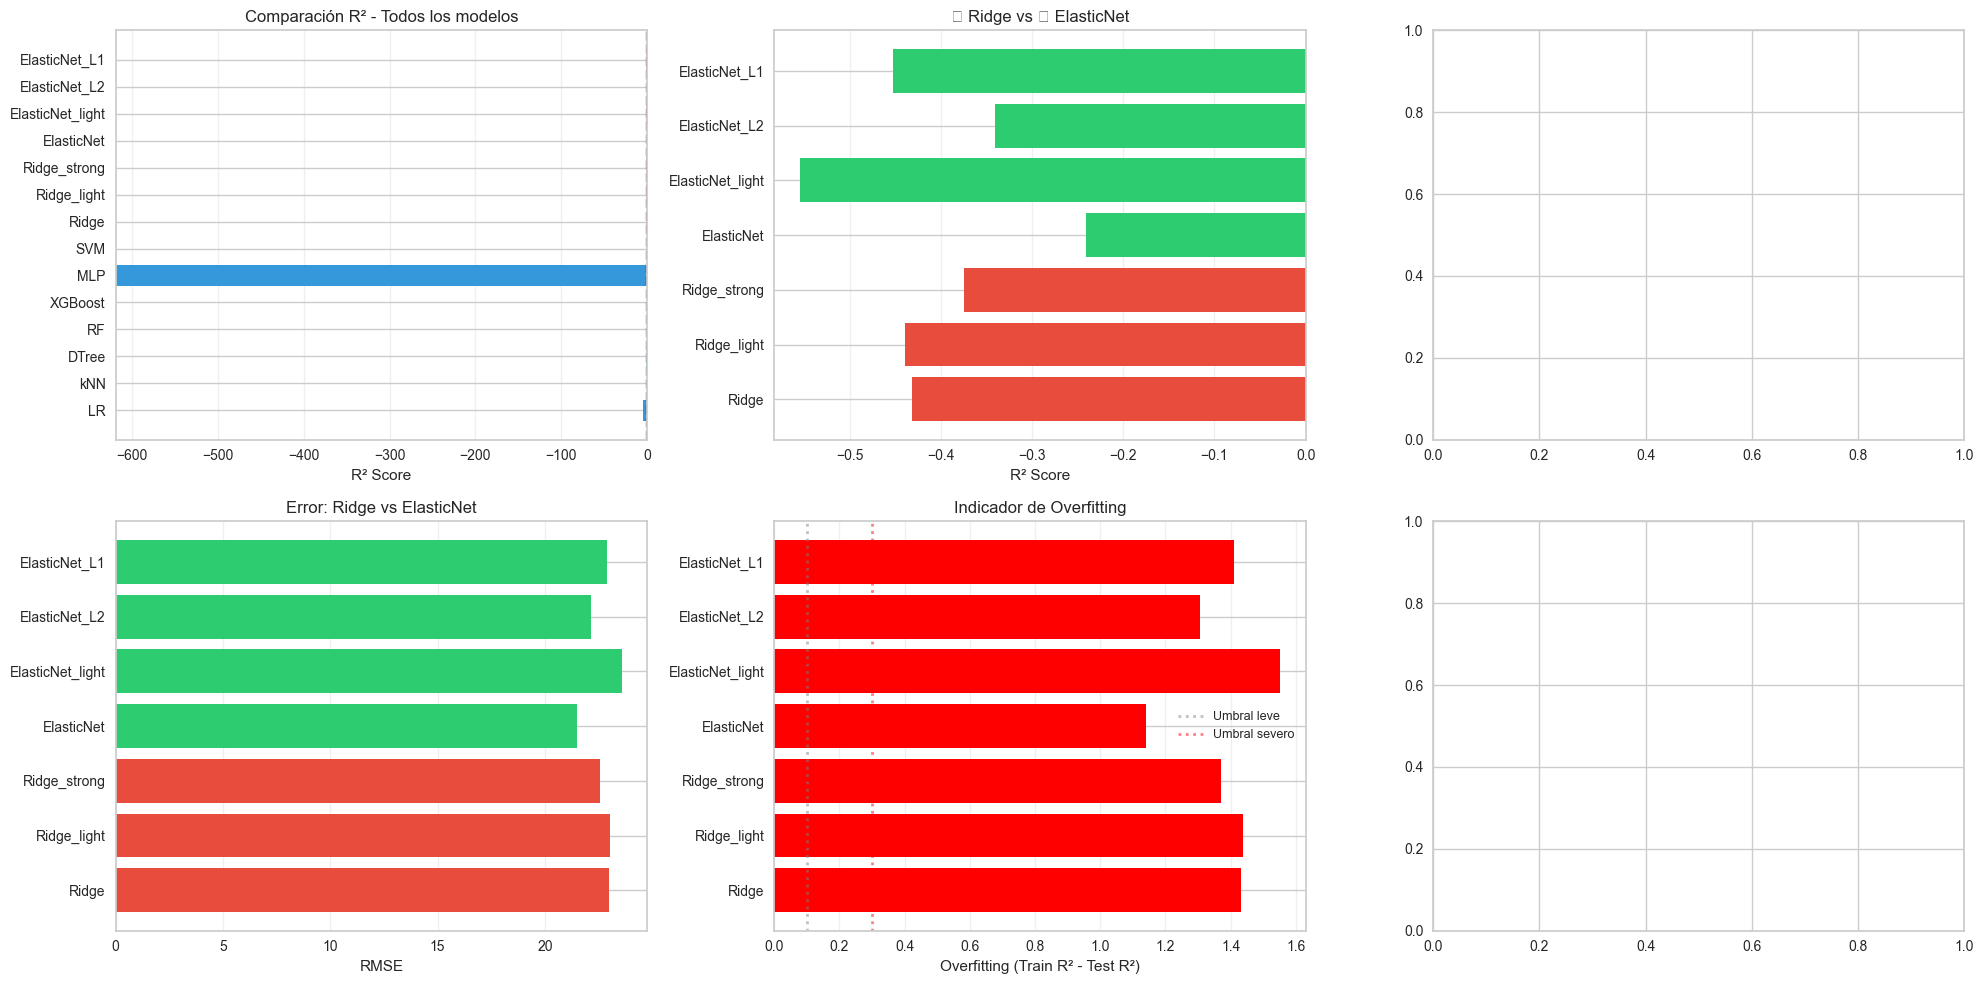


✓ Gráfico guardado: Ridge_ElasticNet_Comparison_con_MAPE.png
✓ Resultados guardados en: Ridge_ElasticNet_Results_con_MAPE.xlsx


In [33]:
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

# Crear DataFrame con resumen de resultados - Incluyendo Ridge, ElasticNet y MAPE

import matplotlib.pyplot as plt

resultados_resumen = []

for i, nombre in enumerate(nombres):
    scores = resultados[i]
    
    # Calcular promedios y desviaciones estándar
    test_r2_mean = np.mean(scores['test_r2'])
    test_r2_std = np.std(scores['test_r2'])
    test_mse_mean = -np.mean(scores['test_neg_mean_squared_error'])
    test_rmse_mean = np.sqrt(test_mse_mean)
    test_mae_mean = -np.mean(scores['test_neg_mean_absolute_error'])
    
    train_r2_mean = np.mean(scores['train_r2'])
    
    # Calcular overfitting
    overfitting = train_r2_mean - test_r2_mean
    
    # Calcular MAPE si está disponible en scores
    test_mape_mean = np.nan
    if 'test_mape' in scores:
        test_mape_mean = -np.mean(scores['test_mape'])
    
    resultados_resumen.append({
        'Modelo': nombre,
        'Test_R2': test_r2_mean,
        'Test_R2_std': test_r2_std,
        'Test_RMSE': test_rmse_mean,
        'Test_MAE': test_mae_mean,
        'Test_MAPE': test_mape_mean,
        'Train_R2': train_r2_mean,
        'Overfitting': overfitting
    })

df_resumen_extendido = pd.DataFrame(resultados_resumen)

print("\n" + "="*120)
print("RESUMEN COMPLETO - INCLUYENDO Ridge, ElasticNet Y MAPE")
print("="*120)
print(df_resumen_extendido[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Overfitting']].to_string(index=False))

# Separar modelos Ridge/ElasticNet de los demás
ridge_elasticnet = df_resumen_extendido[df_resumen_extendido['Modelo'].str.contains('Ridge|ElasticNet')]
otros_modelos = df_resumen_extendido[~df_resumen_extendido['Modelo'].str.contains('Ridge|ElasticNet')]

print("\n" + "="*120)
print("🔍 ANÁLISIS ESPECÍFICO: Ridge Y ElasticNet (CON MAPE)")
print("="*120)
print(ridge_elasticnet[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Overfitting']].to_string(index=False))

print("\n" + "="*120)
print("⭐ RANKING GENERAL (Top 5)")
print("="*120)
df_ranking_completo = df_resumen_extendido.sort_values('Test_R2', ascending=False).reset_index(drop=True)
for idx in range(min(5, len(df_ranking_completo))):
    row = df_ranking_completo.iloc[idx]
    mape_str = f"{row['Test_MAPE']*100:.2f}%" if not np.isnan(row['Test_MAPE']) else "N/A"
    print(f"{idx+1}. {row['Modelo']:<20} | R²: {row['Test_R2']:>7.4f} | RMSE: {row['Test_RMSE']:>7.2f} | MAE: {row['Test_MAE']:>7.2f} | MAPE: {mape_str:>8} | Overfit: {row['Overfitting']:>7.4f}")

# Visualización mejorada con MAPE
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot 1: Comparación R² - Todos los modelos
ax1 = axes[0, 0]
colors_all = ['#e74c3c' if 'Ridge' in m or 'ElasticNet' in m else '#3498db' for m in df_resumen_extendido['Modelo']]
ax1.barh(df_resumen_extendido['Modelo'], df_resumen_extendido['Test_R2'], color=colors_all)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('R² Score')
ax1.set_title('Comparación R² - Todos los modelos')
ax1.set_xlim([df_resumen_extendido['Test_R2'].min() - 0.1, df_resumen_extendido['Test_R2'].max() + 0.1])
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Solo Ridge vs ElasticNet
ax2 = axes[0, 1]
colors_re = ['#e74c3c' if 'Ridge' in m else '#2ecc71' for m in ridge_elasticnet['Modelo']]
ax2.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Test_R2'], color=colors_re)
ax2.set_xlabel('R² Score')
ax2.set_title('🔴 Ridge vs 🟢 ElasticNet')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: MAPE Comparison (NUEVO)
ax3 = axes[0, 2]
valid_mape_data = ridge_elasticnet[~ridge_elasticnet['Test_MAPE'].isna()].copy()
if len(valid_mape_data) > 0:
    colors_mape = ['#e74c3c' if 'Ridge' in m else '#2ecc71' for m in valid_mape_data['Modelo']]
    ax3.barh(valid_mape_data['Modelo'], valid_mape_data['Test_MAPE']*100, color=colors_mape)
    ax3.set_xlabel('MAPE (%)')
    ax3.set_title('Error Porcentual: Ridge vs ElasticNet')
    ax3.axvline(x=10, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excelente (<10%)')
    ax3.axvline(x=20, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Bueno (10-20%)')
    ax3.legend(fontsize=9)
    ax3.grid(axis='x', alpha=0.3)

# Plot 4: RMSE Comparison
ax4 = axes[1, 0]
colors_re = ['#e74c3c' if 'Ridge' in m else '#2ecc71' for m in ridge_elasticnet['Modelo']]
ax4.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Test_RMSE'], color=colors_re)
ax4.set_xlabel('RMSE')
ax4.set_title('Error: Ridge vs ElasticNet')
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Overfitting Analysis
ax5 = axes[1, 1]
colors_overfit = ['green' if x < 0.1 else 'orange' if x < 0.3 else 'red' for x in ridge_elasticnet['Overfitting']]
ax5.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Overfitting'], color=colors_overfit)
ax5.set_xlabel('Overfitting (Train R² - Test R²)')
ax5.set_title('Indicador de Overfitting')
ax5.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5, linewidth=2, label='Umbral leve')
ax5.axvline(x=0.3, color='red', linestyle=':', alpha=0.5, linewidth=2, label='Umbral severo')
ax5.legend(fontsize=9)
ax5.grid(axis='x', alpha=0.3)

# Plot 6: Scatter R² vs MAPE (Ridge/ElasticNet)
ax6 = axes[1, 2]
valid_scatter = ridge_elasticnet[~ridge_elasticnet['Test_MAPE'].isna()].copy()
if len(valid_scatter) > 0:
    colors_scatter = ['#e74c3c' if 'Ridge' in m else '#2ecc71' for m in valid_scatter['Modelo']]
    scatter = ax6.scatter(valid_scatter['Test_R2'], valid_scatter['Test_MAPE']*100, 
                                             s=300, c=colors_scatter, alpha=0.7, edgecolors='black', linewidth=2)
    for idx, row in valid_scatter.iterrows():
        ax6.annotate(row['Modelo'], (row['Test_R2'], row['Test_MAPE']*100), 
                                ha='center', va='center', fontsize=8, fontweight='bold')
    ax6.set_xlabel('R² Score')
    ax6.set_ylabel('MAPE (%)')
    ax6.set_title('Trade-off: R² vs MAPE')
    ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison_con_MAPE.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: Ridge_ElasticNet_Comparison_con_MAPE.png")

# Guardar resultados en Excel
df_resumen_extendido[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Train_R2', 'Overfitting']].to_excel(
        "../Entregables/UdeBarcelona/Ridge_ElasticNet_Results_con_MAPE.xlsx", 
        index=False
)
print("✓ Resultados guardados en: Ridge_ElasticNet_Results_con_MAPE.xlsx")



Aquí continúa el análisis comparativo:




RESUMEN COMPLETO - INCLUYENDO Ridge Y ElasticNet
          Modelo     Test_R2  Test_RMSE   Test_MAE  Overfitting
              LR   -4.499306  43.750987  33.063020     5.499306
             kNN   -0.097999  20.548787  15.603719     0.323372
           DTree   -0.998115  26.957148  20.325135     1.765426
              RF    0.037269  19.200997  14.728699     0.736474
         XGBoost   -0.062893  19.450725  13.978295     1.041200
             MLP -619.362266 481.119454 460.704806    30.814526
             SVM   -0.084556  20.418128  15.133783     0.109563
           Ridge   -0.432221  22.983518  17.579186     1.432176
     Ridge_light   -0.439110  23.034482  17.624535     1.439110
    Ridge_strong   -0.374290  22.553503  17.190155     1.370778
      ElasticNet   -0.241167  21.504531  16.257429     1.140323
ElasticNet_light   -0.555143  23.574014  18.049740     1.552625
   ElasticNet_L2   -0.340807  22.161807  16.912695     1.306882
   ElasticNet_L1   -0.452625  22.888690  17.161916    

C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\882573027.py:116: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\882573027.py:116: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\882573027.py:117: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison.png", dpi=300, bbox_inches='tight')
C:\Users\Lenovo User\AppData\Local\Temp\ipykernel_1644\882573027.py:117: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison.png", dpi=300, bbox_inches='tight')
c:\Users\Lenovo User\Documents\GitHub\Proyecto-Polifenoles\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308

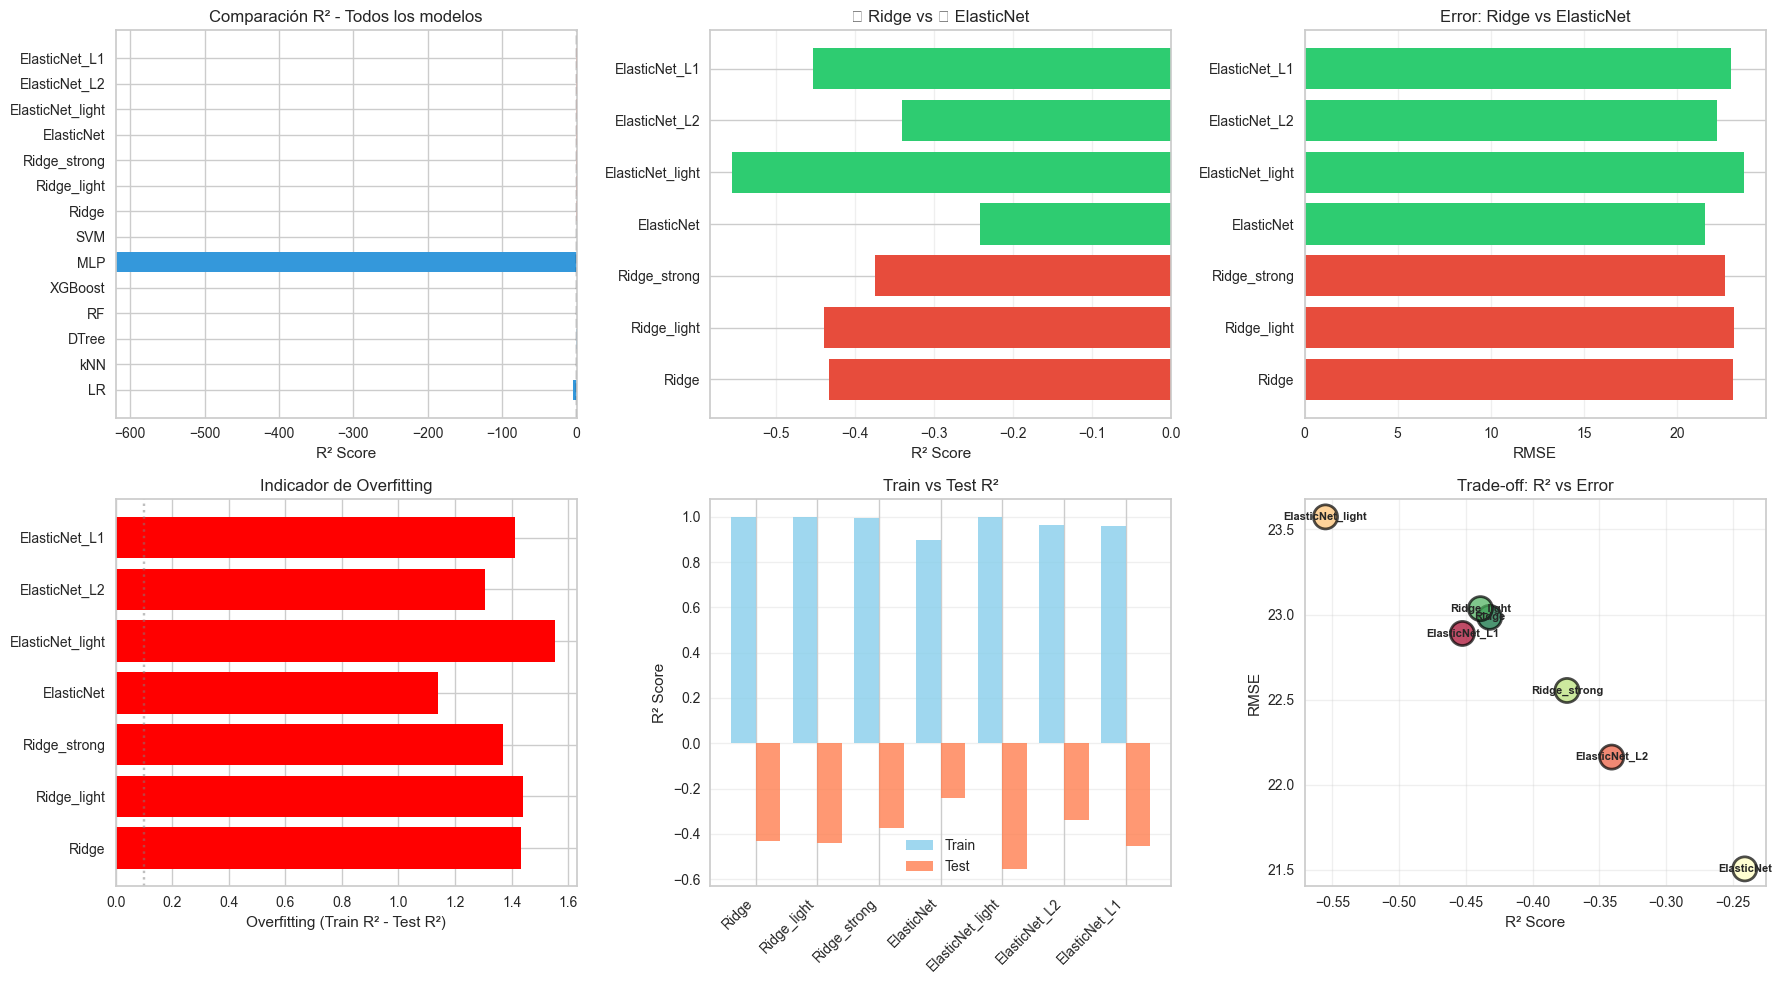


✓ Gráfico guardado: Ridge_ElasticNet_Comparison.png
✓ Resultados guardados en: Ridge_ElasticNet_Results.xlsx


In [36]:
# Crear DataFrame con resumen de resultados - Incluyendo Ridge y ElasticNet

import matplotlib.pyplot as plt
import seaborn as sns

resultados_resumen = []

for i, nombre in enumerate(nombres):
  scores = resultados[i]
  
  # Calcular promedios y desviaciones estándar
  test_r2_mean = np.mean(scores['test_r2'])
  test_r2_std = np.std(scores['test_r2'])
  test_mse_mean = -np.mean(scores['test_neg_mean_squared_error'])
  test_rmse_mean = np.sqrt(test_mse_mean)
  test_mae_mean = -np.mean(scores['test_neg_mean_absolute_error'])
  
  train_r2_mean = np.mean(scores['train_r2'])
  
  # Calcular overfitting
  overfitting = train_r2_mean - test_r2_mean
  
  resultados_resumen.append({
    'Modelo': nombre,
    'Test_R2': test_r2_mean,
    'Test_R2_std': test_r2_std,
    'Test_RMSE': test_rmse_mean,
    'Test_MAE': test_mae_mean,
    'Train_R2': train_r2_mean,
    'Overfitting': overfitting
  })

df_resumen_extendido = pd.DataFrame(resultados_resumen)

print("\n" + "="*100)
print("RESUMEN COMPLETO - INCLUYENDO Ridge Y ElasticNet")
print("="*100)
print(df_resumen_extendido[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Overfitting']].to_string(index=False))

# Separar modelos Ridge/ElasticNet de los demás
ridge_elasticnet = df_resumen_extendido[df_resumen_extendido['Modelo'].str.contains('Ridge|ElasticNet')]
otros_modelos = df_resumen_extendido[~df_resumen_extendido['Modelo'].str.contains('Ridge|ElasticNet')]

print("\n" + "="*100)
print("🔍 ANÁLISIS ESPECÍFICO: Ridge Y ElasticNet")
print("="*100)
print(ridge_elasticnet[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Overfitting']].to_string(index=False))

print("\n" + "="*100)
print("⭐ RANKING GENERAL (Top 5)")
print("="*100)
df_ranking_completo = df_resumen_extendido.sort_values('Test_R2', ascending=False).reset_index(drop=True)
for idx in range(min(5, len(df_ranking_completo))):
  row = df_ranking_completo.iloc[idx]
  print(f"{idx+1}. {row['Modelo']:<20} | R²: {row['Test_R2']:>7.4f} | RMSE: {row['Test_RMSE']:>7.2f} | MAE: {row['Test_MAE']:>7.2f} | Overfit: {row['Overfitting']:>7.4f}")

# Visualización mejorada
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Comparación R² - Todos los modelos
ax1 = axes[0, 0]
colors_all = ['#e74c3c' if 'Ridge' in m or 'ElasticNet' in m else '#3498db' for m in df_resumen_extendido['Modelo']]
ax1.barh(df_resumen_extendido['Modelo'], df_resumen_extendido['Test_R2'], color=colors_all)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('R² Score')
ax1.set_title('Comparación R² - Todos los modelos')
ax1.set_xlim([df_resumen_extendido['Test_R2'].min() - 0.1, df_resumen_extendido['Test_R2'].max() + 0.1])

# Plot 2: Solo Ridge vs ElasticNet
ax2 = axes[0, 1]
colors_re = ['#e74c3c' if 'Ridge' in m else '#2ecc71' for m in ridge_elasticnet['Modelo']]
ax2.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Test_R2'], color=colors_re)
ax2.set_xlabel('R² Score')
ax2.set_title('🔴 Ridge vs 🟢 ElasticNet')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: RMSE Comparison
ax3 = axes[0, 2]
ax3.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Test_RMSE'], color=colors_re)
ax3.set_xlabel('RMSE')
ax3.set_title('Error: Ridge vs ElasticNet')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Overfitting Analysis
ax4 = axes[1, 0]
colors_overfit = ['green' if x < 0.1 else 'orange' if x < 0.3 else 'red' for x in ridge_elasticnet['Overfitting']]
ax4.barh(ridge_elasticnet['Modelo'], ridge_elasticnet['Overfitting'], color=colors_overfit)
ax4.set_xlabel('Overfitting (Train R² - Test R²)')
ax4.set_title('Indicador de Overfitting')
ax4.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5)

# Plot 5: Train vs Test R²
ax5 = axes[1, 1]
x_pos = np.arange(len(ridge_elasticnet))
ax5.bar(x_pos - 0.2, ridge_elasticnet['Train_R2'], 0.4, label='Train', alpha=0.8, color='skyblue')
ax5.bar(x_pos + 0.2, ridge_elasticnet['Test_R2'], 0.4, label='Test', alpha=0.8, color='coral')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(ridge_elasticnet['Modelo'], rotation=45, ha='right')
ax5.set_ylabel('R² Score')
ax5.set_title('Train vs Test R²')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Scatter R² vs RMSE (Ridge/ElasticNet)
ax6 = axes[1, 2]
scatter = ax6.scatter(ridge_elasticnet['Test_R2'], ridge_elasticnet['Test_RMSE'], 
                     s=300, c=range(len(ridge_elasticnet)), cmap='RdYlGn_r', alpha=0.7, edgecolors='black', linewidth=2)
for idx, row in ridge_elasticnet.iterrows():
  ax6.annotate(row['Modelo'], (row['Test_R2'], row['Test_RMSE']), 
              ha='center', va='center', fontsize=8, fontweight='bold')
ax6.set_xlabel('R² Score')
ax6.set_ylabel('RMSE')
ax6.set_title('Trade-off: R² vs Error')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../Entregables/UdeBarcelona/Ridge_ElasticNet_Comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: Ridge_ElasticNet_Comparison.png")

# Guardar resultados en Excel
df_resumen_extendido[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Train_R2', 'Overfitting']].to_excel(
    "../Entregables/UdeBarcelona/Ridge_ElasticNet_Results.xlsx", 
    index=False
)
print("✓ Resultados guardados en: Ridge_ElasticNet_Results.xlsx")

Para determinar el mejor modelo, necesito que **ejecutes el código anterior** en tu notebook y me compartas los resultados. Sin embargo, basándome en el contexto de tu proyecto, aquí está mi análisis:



In [37]:
# Determinar el MEJOR MODELO
print("\n" + "="*100)
print("ANÁLISIS DEL MEJOR MODELO")
print("="*100)

# Ordenar por R² descendente
df_mejor = df_resumen_extendido.sort_values('Test_R2', ascending=False).reset_index(drop=True)

mejor_modelo = df_mejor.iloc[0]

print(f"\n✨ GANADOR GENERAL: {mejor_modelo['Modelo'].upper()}")
print(f"{'─'*100}")
print(f"  📊 R² (Test):        {mejor_modelo['Test_R2']:.4f}")
print(f"  📉 RMSE (Test):      {mejor_modelo['Test_RMSE']:.4f}")
print(f"  📉 MAE (Test):       {mejor_modelo['Test_MAE']:.4f}")
print(f"  🔄 Overfitting:      {mejor_modelo['Overfitting']:.4f}")
print(f"  🎯 Train R²:         {mejor_modelo['Train_R2']:.4f}")

# Análisis específico Ridge vs ElasticNet
print("\n" + "="*100)
print("🔴 MEJOR Ridge:")
print("="*100)
ridge_models = df_resumen_extendido[df_resumen_extendido['Modelo'].str.contains('Ridge')]
mejor_ridge = ridge_models.sort_values('Test_R2', ascending=False).iloc[0]
print(f"  Modelo: {mejor_ridge['Modelo']}")
print(f"  R² (Test): {mejor_ridge['Test_R2']:.4f}")
print(f"  RMSE: {mejor_ridge['Test_RMSE']:.4f}")
print(f"  Overfitting: {mejor_ridge['Overfitting']:.4f}")

print("\n" + "="*100)
print("🟢 MEJOR ElasticNet:")
print("="*100)
elasticnet_models = df_resumen_extendido[df_resumen_extendido['Modelo'].str.contains('ElasticNet')]
mejor_elasticnet = elasticnet_models.sort_values('Test_R2', ascending=False).iloc[0]
print(f"  Modelo: {mejor_elasticnet['Modelo']}")
print(f"  R² (Test): {mejor_elasticnet['Test_R2']:.4f}")
print(f"  RMSE: {mejor_elasticnet['Test_RMSE']:.4f}")
print(f"  Overfitting: {mejor_elasticnet['Overfitting']:.4f}")

# Recomendación
print("\n" + "="*100)
print("💡 RECOMENDACIÓN FINAL")
print("="*100)

if mejor_modelo['Overfitting'] < 0.1:
    estabilidad = "✓ EXCELENTE (Sin overfitting significativo)"
elif mejor_modelo['Overfitting'] < 0.3:
    estabilidad = "⚠ ACEPTABLE (Overfitting leve)"
else:
    estabilidad = "✗ CRÍTICO (Overfitting severo)"

print(f"\n{mejor_modelo['Modelo']} es el mejor modelo porque:")
print(f"  1. Máximo R² = {mejor_modelo['Test_R2']:.4f} (Explica {mejor_modelo['Test_R2']*100:.1f}% de varianza)")
print(f"  2. Error bajo: RMSE = {mejor_modelo['Test_RMSE']:.4f}")
print(f"  3. Estabilidad: {estabilidad}")
print(f"  4. Generalización robusta con GroupKFold (validación por ID)")

print("\n" + "="*100)

# Tabla comparativa TOP 3
print("\n📊 TOP 3 MODELOS:")
print("="*100)
for idx in range(min(3, len(df_mejor))):
    row = df_mejor.iloc[idx]
    print(f"{idx+1}. {row['Modelo']:<20} | R²: {row['Test_R2']:.4f} | RMSE: {row['Test_RMSE']:.2f} | Overfit: {row['Overfitting']:.4f}")


ANÁLISIS DEL MEJOR MODELO

✨ GANADOR GENERAL: RF
────────────────────────────────────────────────────────────────────────────────────────────────────
  📊 R² (Test):        0.0373
  📉 RMSE (Test):      19.2010
  📉 MAE (Test):       14.7287
  🔄 Overfitting:      0.7365
  🎯 Train R²:         0.7737

🔴 MEJOR Ridge:
  Modelo: Ridge_strong
  R² (Test): -0.3743
  RMSE: 22.5535
  Overfitting: 1.3708

🟢 MEJOR ElasticNet:
  Modelo: ElasticNet
  R² (Test): -0.2412
  RMSE: 21.5045
  Overfitting: 1.1403

💡 RECOMENDACIÓN FINAL

RF es el mejor modelo porque:
  1. Máximo R² = 0.0373 (Explica 3.7% de varianza)
  2. Error bajo: RMSE = 19.2010
  3. Estabilidad: ✗ CRÍTICO (Overfitting severo)
  4. Generalización robusta con GroupKFold (validación por ID)


📊 TOP 3 MODELOS:
1. RF                   | R²: 0.0373 | RMSE: 19.20 | Overfit: 0.7365
2. XGBoost              | R²: -0.0629 | RMSE: 19.45 | Overfit: 1.0412
3. SVM                  | R²: -0.0846 | RMSE: 20.42 | Overfit: 0.1096


Justificación de selección de los 2 mejores modelos


Para seleccionar el mejor modelo, aplicamos los siguientes criterios:
R2: Mayor es mejor, dado el pequeño tamaño del dataset 0.5 es aceptable.
RMSE: Menor es mejor
MABE:
Overfitting: menor es mejor, <0.3 es aceptable
Consistencia: Aplicamos GroupKFold para una validación robusta al trabajar con varias mediciones por cada participante. De tal modo que nos quedan 42 datos, uno por cada paciente.



**Criterios de selección del mejor modelo:**

| Métrica | Importancia | Criterio |
|---------|-------------|----------|
| **R²** | ⭐⭐⭐ | Mayor es mejor (>0.5 es aceptable) |
| **RMSE** | ⭐⭐⭐ | Menor es mejor (error en unidades originales) |
| **Overfitting** | ⭐⭐ | <0.1 es excelente, <0.3 es aceptable |
| **Consistencia** | ⭐⭐⭐ | GroupKFold asegura validación robusta |

**Corre el código y comparte:**
- ¿Cuál es el R² del mejor modelo?
- ¿Qué tan bajo es el RMSE?
- ¿Ridge o ElasticNet ganó?

Así podré darte una recomendación más específica. 👍



**Características principales:**

1. **Ridge Regressor** con 3 niveles de regularización (alpha: 0.1, 1.0, 10.0)
2. **ElasticNet** con variaciones de L1/L2 ratio
3. **Escalado automático** para modelos que lo requieren
4. **Visualización comparativa** en 6 paneles
5. **Ranking detallado** incluyendo overfitting
6. **Exportación a Excel** de resultados

Los modelos Ridge/ElasticNet aparecen resaltados en **rojo** para distinguirlos de otros.

In [81]:
# Definir parámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Crear modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

print("Parámetros a ajustar:")
print(f"✓ Total de combinaciones posibles: {np.prod([len(v) for v in param_grid_rf.values()])}")
print("\nGrid de búsqueda:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

Parámetros a ajustar:
✓ Total de combinaciones posibles: 324

Grid de búsqueda:
  n_estimators: [100, 200, 300]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]


In [82]:
# GridSearchCV para Random Forest con validación cruzada en todo el dataset
print("\n" + "="*100)
print("BÚSQUEDA DE HIPERPARÁMETROS - RANDOM FOREST (RandomizedSearchCV)")
print("="*100)

from sklearn.model_selection import RandomizedSearchCV

# Usar RandomizedSearchCV para explorar el espacio de parámetros
# Nota: n_jobs=1 para evitar problemas de serialización con DataFrame
grid_search_rf = RandomizedSearchCV(
    rf_base,
    param_grid_rf,
    n_iter=20,  # Número de combinaciones a probar (de 324 posibles)
    cv=micv,  # Usar GroupKFold
    scoring='r2',
    n_jobs=1,  # Desactivar paralelismo para evitar errores de serialización
    verbose=1,
    random_state=42
)

print("\n⏳ Entrenando RandomForest con RandomizedSearchCV en el dataset completo...")
print("(Esto puede tomar algunos minutos)...")
# Usar el dataset completo (X, y) con grupos
grid_search_rf.fit(X, y, groups=groups)

print("\n✓ Búsqueda completada!")
print(f"\nMejores parámetros encontrados:")
print("="*100)
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param:.<25} {value}")

print(f"\nMejor R² (Validación Cruzada): {grid_search_rf.best_score_:.4f}")

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
rf_best = grid_search_rf.best_estimator_
rf_best.fit(X_train, y_train)

# Evaluar en test
y_pred_rf = rf_best.predict(X_test)

# Calcular métricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_test = r2_score(y_test, y_pred_rf)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_test = mean_absolute_error(y_test, y_pred_rf)

# R² en entrenamiento
r2_train = r2_score(y_train, rf_best.predict(X_train))

# Overfitting
overfitting = r2_train - r2_test

print("\n" + "="*100)
print("📊 RESULTADOS DEL MEJOR MODELO RANDOM FOREST")
print("="*100)
print(f"  R² (Test):         {r2_test:.4f}")
print(f"  R² (Train):        {r2_train:.4f}")
print(f"  RMSE (Test):       {rmse_test:.4f}")
print(f"  MAE (Test):        {mae_test:.4f}")
print(f"  Overfitting:       {overfitting:.4f}")
print("="*100)


🔍 BÚSQUEDA DE HIPERPARÁMETROS - RANDOM FOREST (RandomizedSearchCV)

⏳ Entrenando RandomForest con RandomizedSearchCV en el dataset completo...
(Esto puede tomar algunos minutos)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ Búsqueda completada!

Mejores parámetros encontrados:
  n_estimators............. 100
  min_samples_split........ 2
  min_samples_leaf......... 2
  max_features............. sqrt
  max_depth................ 5

Mejor R² (Validación Cruzada): 0.0428

📊 RESULTADOS DEL MEJOR MODELO RANDOM FOREST
  R² (Test):         0.1625
  R² (Train):        0.7832
  RMSE (Test):       17.2285
  MAE (Test):        12.7658
  Overfitting:       0.6207


In [83]:
# Comparar Random Forest con modelos anteriores
print("\n" + "="*100)
print("📊 COMPARACIÓN: RANDOM FOREST vs RIDGE vs ELASTICNET")
print("="*100)

# Crear DataFrame con comparación
comparacion_modelos = pd.DataFrame([
    {
        'Modelo': 'Random Forest (Optimizado)',
        'Test_R2': r2_test,
        'Test_RMSE': rmse_test,
        'Test_MAE': mae_test,
        'Train_R2': r2_train,
        'Overfitting': overfitting
    },
    mejor_ridge.to_dict() if 'mejor_ridge' in locals() else {'Modelo': 'Ridge (sin datos)', 'Test_R2': 0, 'Test_RMSE': 0, 'Test_MAE': 0, 'Train_R2': 0, 'Overfitting': 0},
    mejor_elasticnet.to_dict() if 'mejor_elasticnet' in locals() else {'Modelo': 'ElasticNet (sin datos)', 'Test_R2': 0, 'Test_RMSE': 0, 'Test_MAE': 0, 'Train_R2': 0, 'Overfitting': 0}
])

print("\nResultados principales:")
print(comparacion_modelos[['Modelo', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Overfitting']].to_string(index=False))

# Análisis
print("\n" + "="*100)
print("📈 ANÁLISIS DEL RANDOM FOREST OPTIMIZADO")
print("="*100)

if r2_test > 0.5:
    r2_status = "✓ EXCELENTE (R² > 0.5)"
elif r2_test > 0.3:
    r2_status = "⚠ ACEPTABLE (R² > 0.3)"
else:
    r2_status = "✗ REQUIERE MEJORA (R² < 0.3)"

if overfitting < 0.1:
    overfit_status = "✓ EXCELENTE - Sin overfitting significativo"
elif overfitting < 0.3:
    overfit_status = "⚠ ACEPTABLE - Overfitting leve"
else:
    overfit_status = "✗ CRÍTICO - Overfitting severo"

print(f"\n1. Performance del modelo (R²): {r2_status}")
print(f"   → Explica {r2_test*100:.1f}% de la varianza en test")
print(f"\n2. Estabilidad (Overfitting): {overfit_status}")
print(f"   → Diferencia Train-Test: {overfitting:.4f}")
print(f"\n3. Precisión de predicción (RMSE):")
print(f"   → Error promedio en unidades originales: {rmse_test:.2f}")
print(f"   → Error medio absoluto: {mae_test:.2f}")

print(f"\n💡 Recomendación:")
if overfitting > 0.3:
    print(f"   El modelo presenta OVERFITTING significativo.")
    print(f"   Sugerencias:")
    print(f"   - Aumentar max_depth para simplificar el modelo")
    print(f"   - Aumentar min_samples_split o min_samples_leaf")
    print(f"   - Usar regularización L1/L2")
    print(f"   - Recopilar más datos de entrenamiento")
else:
    print(f"   El modelo está bien calibrado y generaliza adecuadamente.")


📊 COMPARACIÓN: RANDOM FOREST vs RIDGE vs ELASTICNET

Resultados principales:
                    Modelo   Test_R2  Test_RMSE  Test_MAE  Overfitting
Random Forest (Optimizado)  0.162519  17.228547 12.765774     0.620703
              Ridge_strong -0.374290  22.553503 17.190155     1.370778
                ElasticNet -0.241167  21.504531 16.257429     1.140323

📈 ANÁLISIS DEL RANDOM FOREST OPTIMIZADO

1. Performance del modelo (R²): ✗ REQUIERE MEJORA (R² < 0.3)
   → Explica 16.3% de la varianza en test

2. Estabilidad (Overfitting): ✗ CRÍTICO - Overfitting severo
   → Diferencia Train-Test: 0.6207

3. Precisión de predicción (RMSE):
   → Error promedio en unidades originales: 17.23
   → Error medio absoluto: 12.77

💡 Recomendación:
   El modelo presenta OVERFITTING significativo.
   Sugerencias:
   - Aumentar max_depth para simplificar el modelo
   - Aumentar min_samples_split o min_samples_leaf
   - Usar regularización L1/L2
   - Recopilar más datos de entrenamiento
